<a href="https://colab.research.google.com/github/Pattiecodes/DataCamp_As.AIEng/blob/main/Certification_PE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Task 1

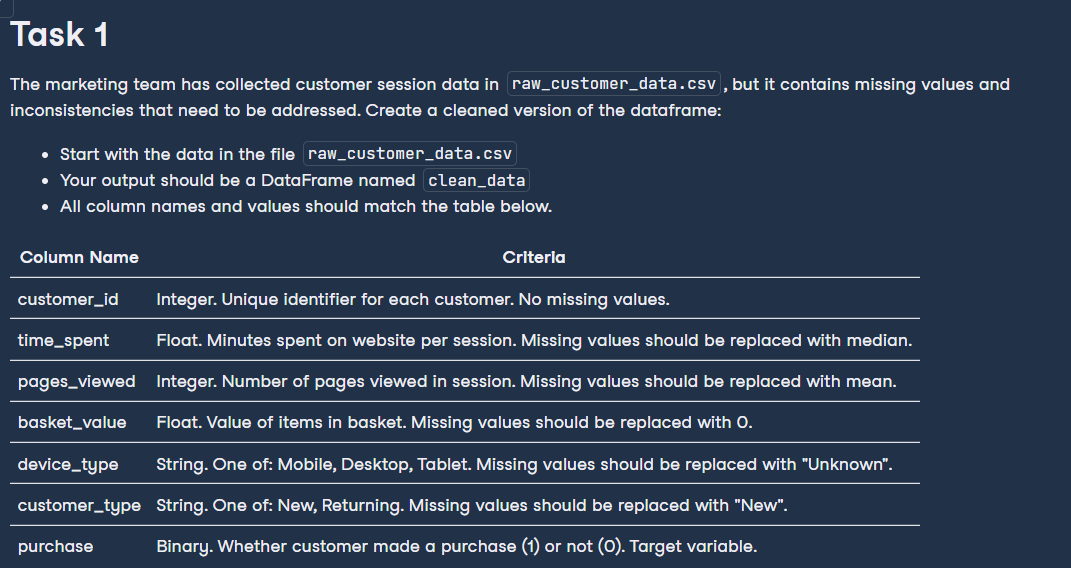

In [ ]:
import pandas as pd

# Load the raw data
raw_data = pd.read_csv("raw_customer_data.csv")

# Clean the data
def clean_customer_data(raw_data):
    # Step 1: Ensure no missing values in 'customer_id'
    clean_data = raw_data.dropna(subset=["customer_id"])
    clean_data["customer_id"] = clean_data["customer_id"].astype(int)  # Ensure it's an integer

    # Step 2: Replace missing values in 'time_spent' with median
    clean_data["time_spent"] = clean_data["time_spent"].fillna(clean_data["time_spent"].median()).astype(float)

    # Step 3: Replace missing values in 'pages_viewed' with mean
    clean_data["pages_viewed"] = clean_data["pages_viewed"].fillna(clean_data["pages_viewed"].mean()).astype(int)

    # Step 4: Replace missing values in 'basket_value' with 0
    clean_data["basket_value"] = clean_data["basket_value"].fillna(0).astype(float)

    # Step 5: Replace missing values in 'device_type' with "Unknown"
    clean_data["device_type"] = clean_data["device_type"].fillna("Unknown")

    # Step 6: Replace missing values in 'customer_type' with "New"
    clean_data["customer_type"] = clean_data["customer_type"].fillna("New")

    # Step 7: Ensure 'purchase' is binary (0 or 1)
    clean_data["purchase"] = clean_data["purchase"].apply(lambda x: 1 if x == 1 else 0)

    return clean_data

# Generate the cleaned DataFrame
clean_data = clean_customer_data(raw_data)

# Save the cleaned data to a new CSV (optional)
clean_data.to_csv("clean_customer_data.csv", index=False)

print(clean_data.head())

# Task 2

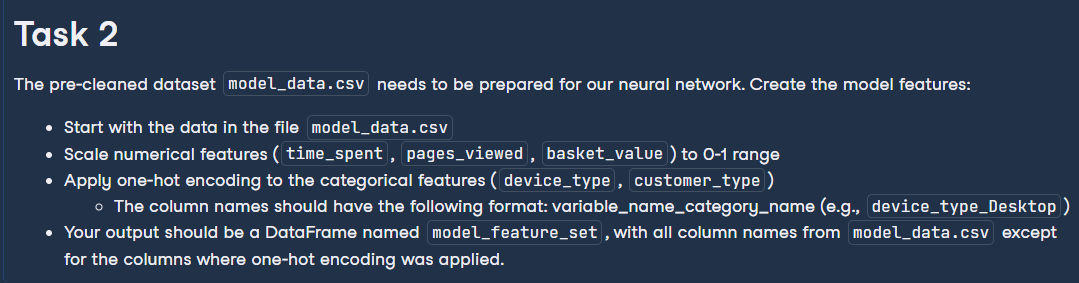

In [ ]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

# Step 1: Load the dataset
model_data = pd.read_csv('model_data.csv')

# Step 2: Scale numerical features
numerical_features = ['time_spent', 'pages_viewed', 'basket_value']
scaler = MinMaxScaler()
model_data[numerical_features] = scaler.fit_transform(model_data[numerical_features])

# Step 3: One-hot encode categorical features
categorical_features = ['device_type', 'customer_type']
one_hot_encoded_data = pd.get_dummies(model_data[categorical_features], prefix=categorical_features)

# Step 4: Combine the scaled numerical features and one-hot encoded features
model_feature_set = pd.concat([model_data.drop(columns=categorical_features), one_hot_encoded_data], axis=1)

print(model_feature_set.head())  # Display the first few rows of the processed dataset

# Task 3

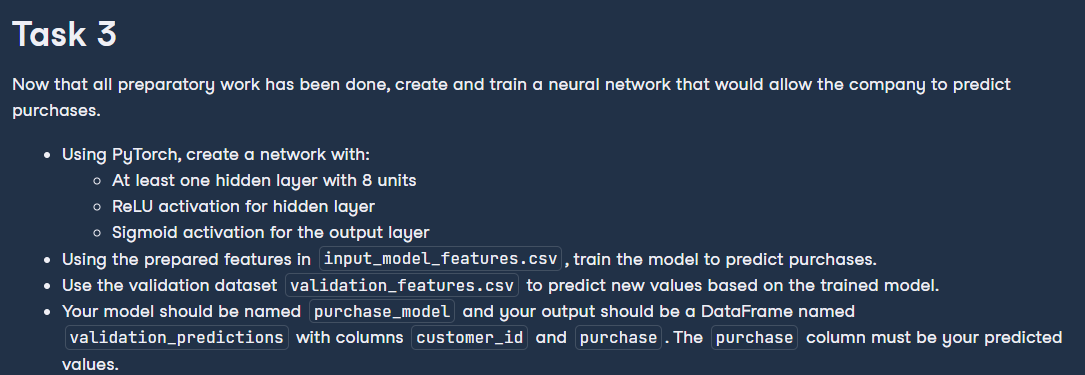

In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import pandas as pd
import numpy as np

# Step 1: Load training and validation datasets
train_data = pd.read_csv('input_model_features.csv')
validation_data = pd.read_csv('validation_features.csv')

# Separate features and labels
X_train = torch.tensor(train_data.drop(columns=['customer_id', 'purchase']).values, dtype=torch.float32)
y_train = torch.tensor(train_data['purchase'].values, dtype=torch.float32)

X_val = torch.tensor(validation_data.drop(columns=['customer_id']).values, dtype=torch.float32)
customer_ids = validation_data['customer_id']

# Step 2: Create a DataLoader for batching
train_dataset = TensorDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)

# Step 3: Define the neural network architecture
class PurchaseModel(nn.Module):
    def __init__(self):
        super(PurchaseModel, self).__init__()
        self.hidden = nn.Linear(X_train.shape[1], 8)  # Input layer to hidden layer
        self.relu = nn.ReLU()                        # Activation for hidden layer
        self.output = nn.Linear(8, 1)                # Hidden layer to output
        self.sigmoid = nn.Sigmoid()                  # Activation for output layer

    def forward(self, x):
        x = self.hidden(x)
        x = self.relu(x)
        x = self.output(x)
        x = self.sigmoid(x)
        return x

# Instantiate the model
purchase_model = PurchaseModel()

# Step 4: Define loss function and optimizer
criterion = nn.BCELoss()  # Binary Cross Entropy Loss
optimizer = torch.optim.Adam(purchase_model.parameters(), lr=0.01)

# Step 5: Train the model
epochs = 20
for epoch in range(epochs):
    for batch in train_loader:
        features, labels = batch
        labels = labels.view(-1, 1)  # Reshape to match the output shape

        # Forward pass
        outputs = purchase_model(features)
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f"Epoch {epoch+1}/{epochs}, Loss: {loss.item()}")

# Step 6: Make predictions on the validation set
with torch.no_grad():
    purchase_predictions = purchase_model(X_val).flatten()  # Flatten for a 1D tensor
    purchase_predictions = (purchase_predictions > 0.5).int()  # Convert probabilities to binary predictions

# Step 7: Create the output DataFrame
validation_predictions = pd.DataFrame({
    'customer_id': customer_ids,
    'purchase': purchase_predictions.numpy()
})

# Save the predictions to a CSV file
validation_predictions.to_csv('validation_predictions.csv', index=False)

print("Model training complete. Predictions saved to 'validation_predictions.csv'.")